## Background

R.S. says:
> Here are the details of the features: Five texture features (energy, entropy, correlation, homogeneity, and contrast) were extracted from T2-w using Haralick descriptors. The features were calculated using the gray-level co-occurrence matrices (GLCM) for each voxel underlying the contoured regions in the image. Voxel-wise texture measures were computed in 28 directions by sliding a window of size 5 × 5 × 5 across the image region enclosing the tumor volume. First, image intensities were rescaled within 0 to 256 range using the entire image. The GLCM was then computed in 3-D using 128 bins in a 5 × 5 × 5 patch centered at each voxel. The texture values for the whole tumor were then summarized using the voxel-wise textures. Nine histogram descriptors (10%, 25%, mean, median, 75%, 90%, stdev, skewness, kurtosis) described above were calculated for each texture feature.

## Initialization

In [1]:
from radiomics import firstorder, shape, glcm
import os, sys
import numpy as np
import SimpleITK as sitk
import pandas as pd

def normalizedImage(image):
    im_arr = sitk.GetArrayFromImage(image).astype(float)    
    print("Intensity range: ", np.min(im_arr), np.max(im_arr))
    im_arr += np.min(im_arr)
    im_arr *= 256 / np.max(im_arr)
    im = sitk.GetImageFromArray(im_arr.astype(int))
    im.CopyInformation(image)
    return im

def getTexture(image,mask,features):
    settings = {"voxelBased": True, "kernelRadius": 2, "binCount": 128}
    gf = glcm.RadiomicsGLCM(image, mask, **settings)
    for f in features:
        gf.enableFeatureByName(f, True)
    return gf.execute()
    
filePrefix = "../cleanedUp"
firstOrderFeatures = [("10","10Percentile"),       # QG58
                      ("90","90Percentile"),       # 8DWT
                      ("mean", "Mean"),            # Q4LE
                      ("SD", "StandardDeviation"), # 
                      ("Kur", "Kurtosis"),         # IPH6 - 3
                      ("Ske", "Skewness"),         # KE2A
                      ("50","Median")              # Y12H
                     ]
shapeFeatures = [("ROI_Vol", "VoxelVolume")]
                 
#                 "t2_int_25", "t2_int_50", "t2_int_mean", \
#"t2_int_75",  , , , "t2_con_10"]

usfFeatures = pd.read_csv(os.path.join(filePrefix,"Challenge_training_T2w.csv"),sep=",")
#####


In [2]:
usfFeatureNames = [f for f in usfFeatures.columns if f.startswith("t2")]
#usfFeatureNames

## Variables

In [3]:
imageFiles = ["subject0000.nrrd","subject0001.nrrd"]
subjects = ["0000", "0001"]
subjects = ["0000"]
maskTypes = ["T_PZ", "F_TZ"]
#maskFileSuffixes = ["subject0000 ROI-1_T_PZ.nrrd", "subject0001 ROI-1_F_TZ.nrrd"]

usfValues = []
prValues = []
subjectValues = []
featureTypes = []

## Make feature images

In [21]:
# generate texture maps
textureNames = [("int", "original"),    # original image
                ("con","Contrast"),     # ACUI
                ("cor","Correlation"),  # NI2N
                ("ene","JointEnergy"),  # 8ZQL
                ("ent","JointEntropy"), # TU9B
                ("hom","Idmn")          # WF0Z
               ]
pyrTextureNames = [i for (_,i) in textureNames if i != "original"]
inputImages = {}
inputMasks = {}
for (i,s) in enumerate(subjects):
    
    fullSubjectID = "ProstateX-"+s
    print("\nProcessing Subject "+fullSubjectID)

    imageFile = os.path.join(filePrefix, "subject%s.nrrd" % s)
    maskFile = os.path.join(filePrefix, "subject%s ROI-1_%s.nrrd" % (s, maskTypes[i]))
    image = sitk.ReadImage(imageFile)

    mask = sitk.ReadImage(maskFile)
    ma_arr = sitk.GetArrayFromImage(mask)
    print("Number of voxels in the mask: "+str(np.sum(ma_arr == 1)))

    sf = shape.RadiomicsShape(image, mask)
    sf.enableFeatureByName('VoxelVolume', True)
    print("Mask volume: pyradiomics:"+str(sf.execute()["VoxelVolume"]/1000.)+" / USF: "+str(usfFeatures[usfFeatures["Patient"]==fullSubjectID]['ROI_Vol'].values[0]))
    
    inputMasks[s] = mask
    
    textureMapsPerSubject = getTexture(normalizedImage(image), mask, pyrTextureNames)
    for (_,tn) in textureNames:
        if tn == "original":
            inputImages[s] = [image]
        else:
            inputImages[s].append(textureMapsPerSubject[tn])


Processing Subject ProstateX-0000
Number of voxels in the mask: 1770
Mask volume: pyradiomics:1.3275009495019925 / USF: 1.3275
Intensity range:  0.0 1118.0


## Original image features

In [15]:
resultsFrame = pd.DataFrame(columns=["Subject","FeatureSource", "FeatureName", "FeatureValue"])


In [22]:
subjectsList = []
featureSourcesList = []
featureNamesList = []
featureValuesList = []

for (subjectI,subject) in enumerate(subjects):
    for (imageI,image) in enumerate(inputImages[subject]):

        usfPrefix = "t2_"+textureNames[imageI][0]
        
        fof = firstorder.RadiomicsFirstOrder(image, inputMasks[subject])
        for (_,prName) in firstOrderFeatures:
            fof.enableFeatureByName(prName, True)
        prResults = fof.execute()    

        for (usfName,prName) in firstOrderFeatures:
            usfName = usfPrefix+"_"+usfName
            usfValue = usfFeatures[usfFeatures["Patient"]==fullSubjectID][usfName].values[0]
            
            # add USF feature
            subjectsList.append(fullSubjectID)
            featureSourcesList.append("USF")
            featureNamesList.append(usfName)
            featureValuesList.append(usfValue)
            
            # add pyradiomics feature
            subjectsList.append(fullSubjectID)
            featureSourcesList.append("pyradiomics")
            featureNamesList.append(prName)
            featureValuesList.append(prResults[prName])
            if prName == "Kurtosis":
                featureValuesList[-1] = featureValuesList[-1]-3.
                
resultsFrame["Subject"] = subjectsList
resultsFrame["FeatureSource"] = featureSourcesList
resultsFrame["FeatureName"] = featureNamesList
resultsFrame["FeatureValue"] = featureValuesList

Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!
Feature StandardDeviation is deprecated, use with caution!


In [23]:
resultsFrame

,Subject,FeatureSource,FeatureName,FeatureValue
0,ProstateX-0000,USF,t2_int_10,163.000000
1,ProstateX-0000,pyradiomics,10Percentile,163.000000
2,ProstateX-0000,USF,t2_int_90,298.000000
3,ProstateX-0000,pyradiomics,90Percentile,298.000000
4,ProstateX-0000,USF,t2_int_mean,231.054237
5,ProstateX-0000,pyradiomics,Mean,231.054237
6,ProstateX-0000,USF,t2_int_SD,53.170815
7,ProstateX-0000,pyradiomics,StandardDeviation,53.155793
8,ProstateX-0000,USF,t2_int_Kur,-0.203380
9,ProstateX-0000,pyradiomics,Kurtosis,-0.206194


## Make plots

In [27]:
resultsFrame[resultsFrame["FeatureSource"]=="pyradiomics"]["FeatureValue"].values

array([ 1.63000000e+02,  2.98000000e+02,  2.31054237e+02,  5.31557927e+01,
       -2.06193687e-01,  1.08702932e-01,  2.30000000e+02,  2.41750519e+02,
        7.29091294e+02,  4.48367916e+02,  2.14572838e+02,  7.95369554e+00,
        1.99963621e+00,  4.06511330e+02, -7.08461742e-02,  3.41746600e-01,
        1.43454652e-01,  1.61212169e-01,  4.01714256e-01, -4.84360726e-01,
        1.58687406e-01,  1.05966160e-02,  4.30766276e-02,  2.50440948e-02,
        3.40383394e-02,  3.77864787e+01,  5.48671780e+00,  1.51287307e-02,
        4.64842855e+00,  6.65700938e+00,  5.86871667e+00,  8.42262000e-01,
        2.43999950e+00, -1.60319090e+00,  6.13777226e+00,  9.61241455e-01,
        9.85919458e-01,  9.75032201e-01,  1.08214989e-02,  6.06665532e+00,
       -1.70433708e+00,  9.76850265e-01])

729.0912943338054


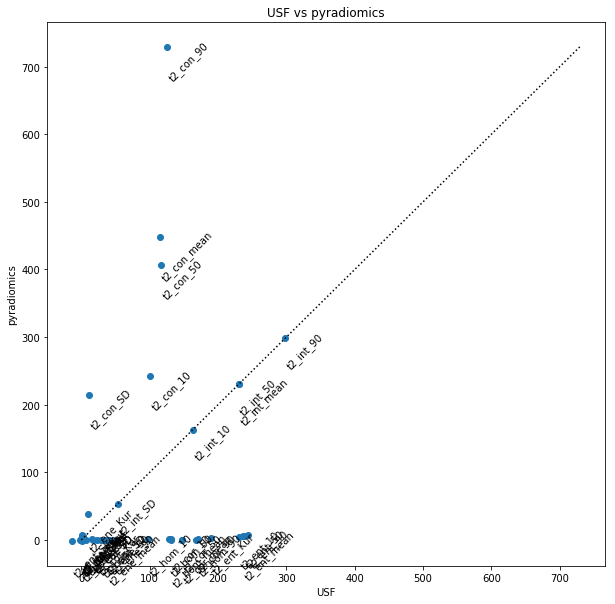

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


# Plot
fig, ax = plt.subplots(figsize=(10, 10))
x = resultsFrame[resultsFrame["FeatureSource"]=="USF"]["FeatureValue"].values
y = resultsFrame[resultsFrame["FeatureSource"]=="pyradiomics"]["FeatureValue"].values

maxF=np.max([np.max(x),np.max(y)])
print(maxF)
annotations = resultsFrame[resultsFrame["FeatureSource"]=="USF"]["FeatureName"].values

ax.scatter(x,y)
ax.plot([0,maxF],[0,maxF],c='black',linestyle=':')

plt.title('USF vs pyradiomics')
plt.xlabel('USF')
plt.ylabel('pyradiomics')


for (i,annotation) in enumerate(annotations):
    ax.annotate(annotation,xy=(x[i],y[i]),rotation=45)

plt.show()

#plt.scatter(usfValues[6:], prValues[6:], c=subjectValues[6:])
#plt.title('USF vs pyradiomics')
#plt.xlabel('USF')
#plt.ylabel('pyradiomics')
#plt.show()